# Wavelet Denoising
In this notebook will we show how to use the Discrete Wavelet Transform (DWT) to denoise images. We will be using [PyWavelets](http://pywavelets.readthedocs.io/en/latest/index.html) for this notebook, which you can install using PIP as 'pip install PyWavelets'.

In [278]:
import skimage.data as data

#load the initial image
image = data.camera()
r, c = image.shape
print(image.shape)

(512, 512)


In [279]:
#create image that looks like noise and inject it into the image
from skimage.util import random_noise
from skimage import exposure #rescale intensities

sigma = 0.05
#generate noisy image
noisy = random_noise(image, var=sigma**2, mode='gaussian')
#get just the noise injected by removing the normalised image that random_noise function uses
image = random_noise(image, var=0, mode='gaussian')
noise = noisy - image
print(noisy.shape)

(512, 512)


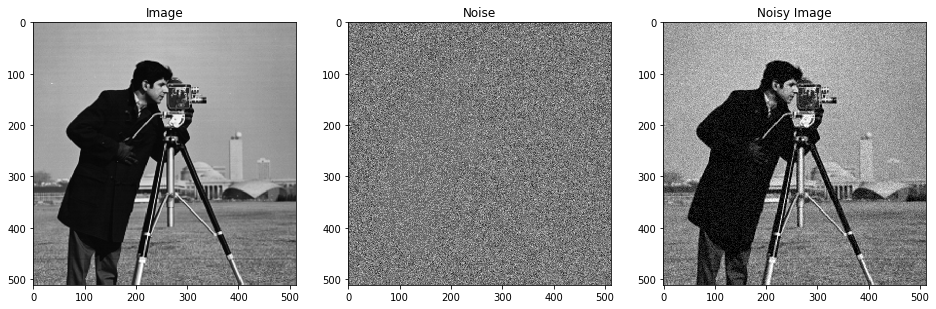

In [280]:
#plot the images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

plt.gray()

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(noise)
ax[1].set_title("Noise")
ax[2].imshow(noisy)
ax[2].set_title("Noisy Image")

plt.show()

## Wavelet Decomposition
Let us now look at the wavelet decomposition of the images and see if we can notice any patterns.

In [281]:
#Wavelet Decomposition for transform sparsity
from skimage import img_as_float
import pywt

motherWavelet = 'haar'
#motherWavelet = 'db4'

wcoeffs1 = pywt.dwt2(img_as_float(image), motherWavelet)
cA, (cH, cV, cD) = wcoeffs1

meanA = np.mean(cA)
meanH = np.mean(cH)
meanV = np.mean(cV)
meanD = np.mean(cD)
print("Mean A:", meanA)
print("Mean H:", meanH)
print("Mean V:", meanV)
print("Mean D:", meanD)

Mean A: 0.927952964633119
Mean H: -0.0013285319010416668
Mean V: 0.0018830542470894605
Mean D: 2.393535539216622e-07


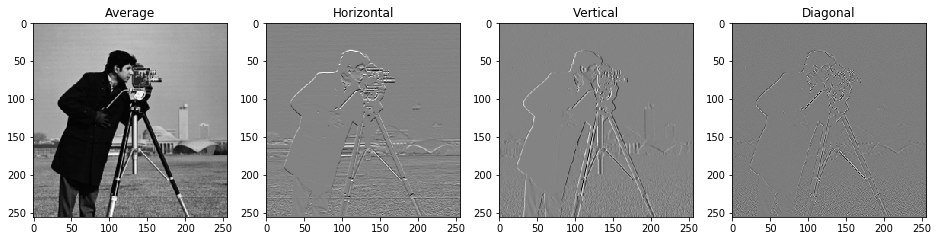

In [282]:
# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

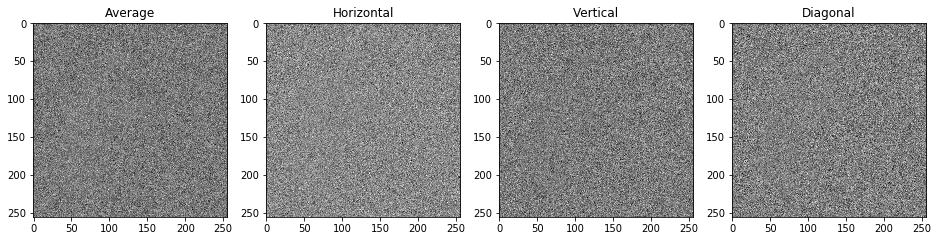

In [283]:
#noise coefficients
wcoeffs2 = pywt.dwt2(noise, motherWavelet)
cA, (cH, cV, cD) = wcoeffs2

# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

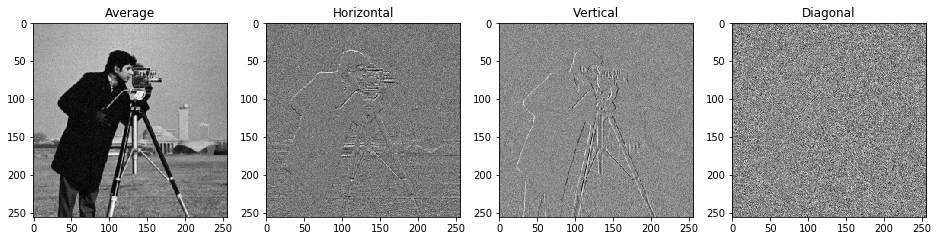

In [284]:
wcoeffs3 = pywt.dwt2(noisy, motherWavelet)
cA, (cH, cV, cD) = wcoeffs3

# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

Let us soft threshold out the noise. We need to estimate the threshold value first. Let's use the median and estimate the noise sigma, then threhold the detail channels. We estimate sigma based on Donoho's (1995) formula 
$$
\sigma = \frac{\textrm{median}_d}{0.6745}
$$
for each detail channel $d$. See "Signal and Image Denoising Using Wavelet Transform" by Burhan Ergen for details.

In [285]:
import numpy as np

#compute the median (use the magnitude as have negative values)
medianH = np.median(np.abs(cH))
medianV = np.median(np.abs(cV))
medianD = np.median(np.abs(cD))

meanH = np.mean(cH)
meanV = np.mean(cV)
meanD = np.mean(cD)
print("Mean H:", meanH)
print("Mean V:", meanV)
print("Mean D:", meanD)

#estimate sigma
sigmaH = medianH/0.6745
sigmaV = medianV/0.6745
sigmaD = medianD/0.6745

#estimate threshold
n = r*c
thresholdH = sigmaH*np.sqrt(2*np.log(n))
print("Threshold H:", thresholdH)
thresholdV = sigmaV*np.sqrt(2*np.log(n))
print("Threshold V:", thresholdV)
thresholdD = sigmaD*np.sqrt(2*np.log(n))
print("Threshold D:", thresholdD)

Mean H: -0.0014396355161110678
Mean V: 0.0019612350108303544
Mean D: -0.00012370146461555763
Threshold H: 0.2674301418024368
Threshold V: 0.27055138904589243
Threshold D: 0.24527209876572703


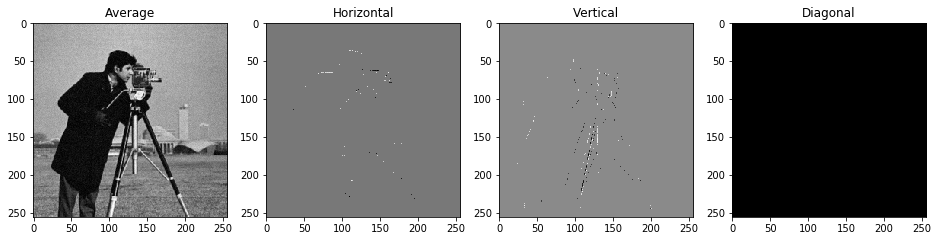

In [286]:
#threshold each detail channel
cH[ np.abs(cH) < thresholdH ] = meanH
cV[ np.abs(cV) < thresholdV ] = meanV
cD[ np.abs(cD) < thresholdD ] = meanD

# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

Finally, reconstruction the image using the inverse DWT to get the denoised image.

In [287]:
#reform coefficients
wcoeffs3 = cA, (cH, cV, cD)

denoised = pywt.idwt2(wcoeffs3, motherWavelet)

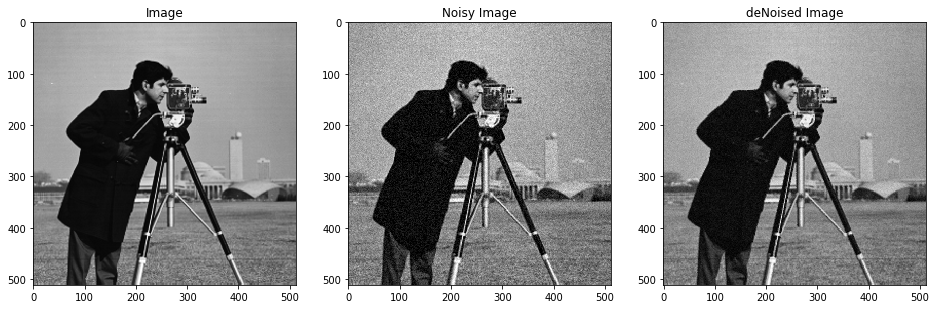

In [288]:
#plot and compare
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

plt.gray()

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(noisy)
ax[1].set_title("Noisy Image")
ax[2].imshow(denoised)
ax[2].set_title("deNoised Image")

plt.show()

In [289]:
#compute quantitiative measure of denoising effectiveness
def immse(img1, img2):
    '''
    Compute the MSE of two images
    '''
    mse = ((img1 - img2) ** 2).mean(axis=None)
    
    return mse

def impsnr(img1, img2, maxPixel=255):
    '''
    Compute the MSE of two images
    '''
    mse = immse(img1,img2)
    psnr_out = 20 * math.log(maxPixel / math.sqrt(mse), 10)
    
    return psnr_out

maxValue = image.max()
print("Noisy PSNR", impsnr(image, noisy, maxPixel=maxValue))
print("deNoised PSNR", impsnr(image, denoised, maxPixel=maxValue))

Noisy PSNR 26.253426064149686
deNoised PSNR 29.137447092615062
